# Прогнозирование заказов такси

## Описание задачи

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

## Описание данных


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Описание задачи в терминах машинного обучения

- Метрика RMSE не больше 48
- Временные ряды
- Регрессия

## Подключение библиотек

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import xgboost as xgb

from math import sqrt

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

RANDOM_STATE = 12345

## Получение данных

In [2]:
try:
    df = pd.read_csv('/datasets/taxi.csv')
except:
    df = pd.read_csv('./datasets/taxi.csv')
cdf = df.copy()
cdf

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
...,...,...
26491,2018-08-31 23:10:00,32
26492,2018-08-31 23:20:00,24
26493,2018-08-31 23:30:00,27
26494,2018-08-31 23:40:00,39


In [3]:
cdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


## Предобработка данных

Изменим тип данных колонки `datetime` на `datetime64`

In [4]:
cdf['datetime'] = cdf['datetime'].astype('datetime64')

Изменяем индекс датафрейма на колонку `datetime`

In [5]:
cdf.set_index('datetime', inplace=True)

Сортируем данные

In [6]:
cdf.sort_index(inplace=True)

Проверяем монотонность

In [7]:
print(cdf.index.is_monotonic)

True


C:\Users\dimka\AppData\Local\Temp\ipykernel_10788\332352371.py:1: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  print(cdf.index.is_monotonic)


Временной ряд монотонный — значения времени расположены в хронологическом порядке (по порядку)

Сделаем ресемплирование по 1 часу

In [10]:
cdf = cdf.resample('1H').sum()

## Изучение данных

In [11]:
cdf

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


In [12]:
cdf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


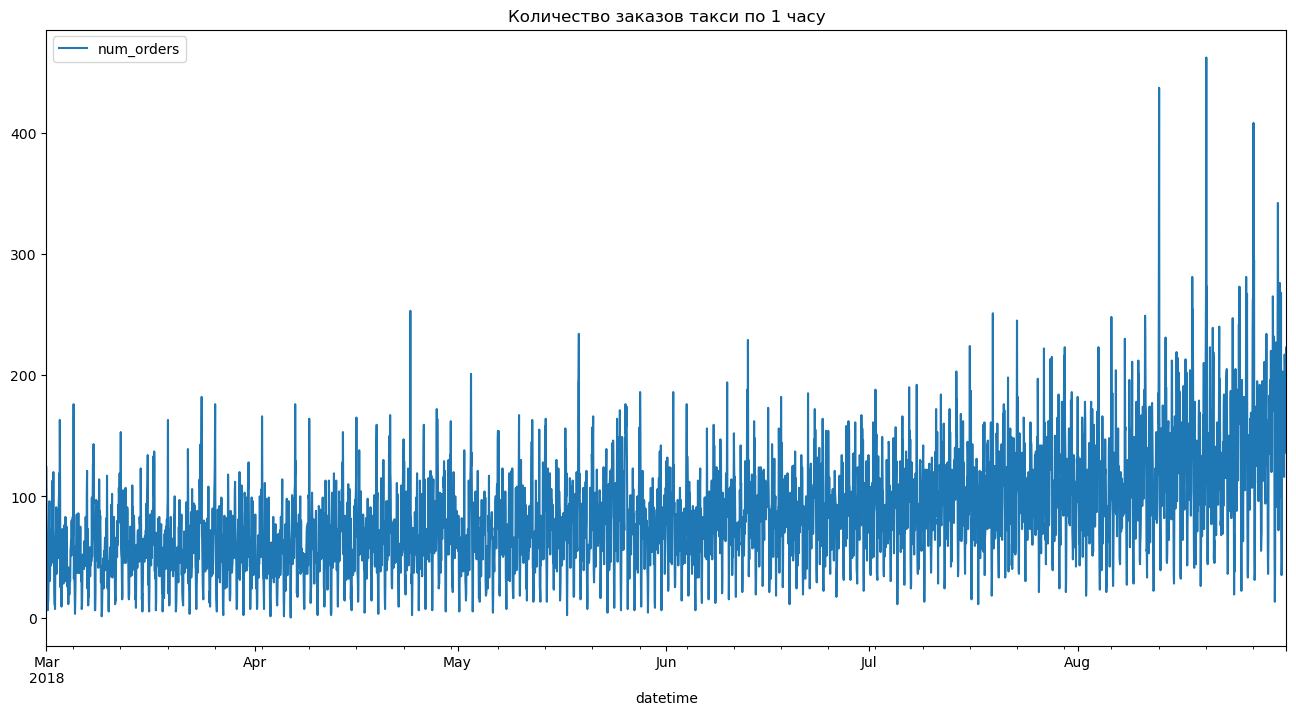

In [13]:
cdf.plot(figsize=(16, 8)).set_title('Количество заказов такси по 1 часу');

## Анализ

In [14]:
decomposed = seasonal_decompose(cdf)

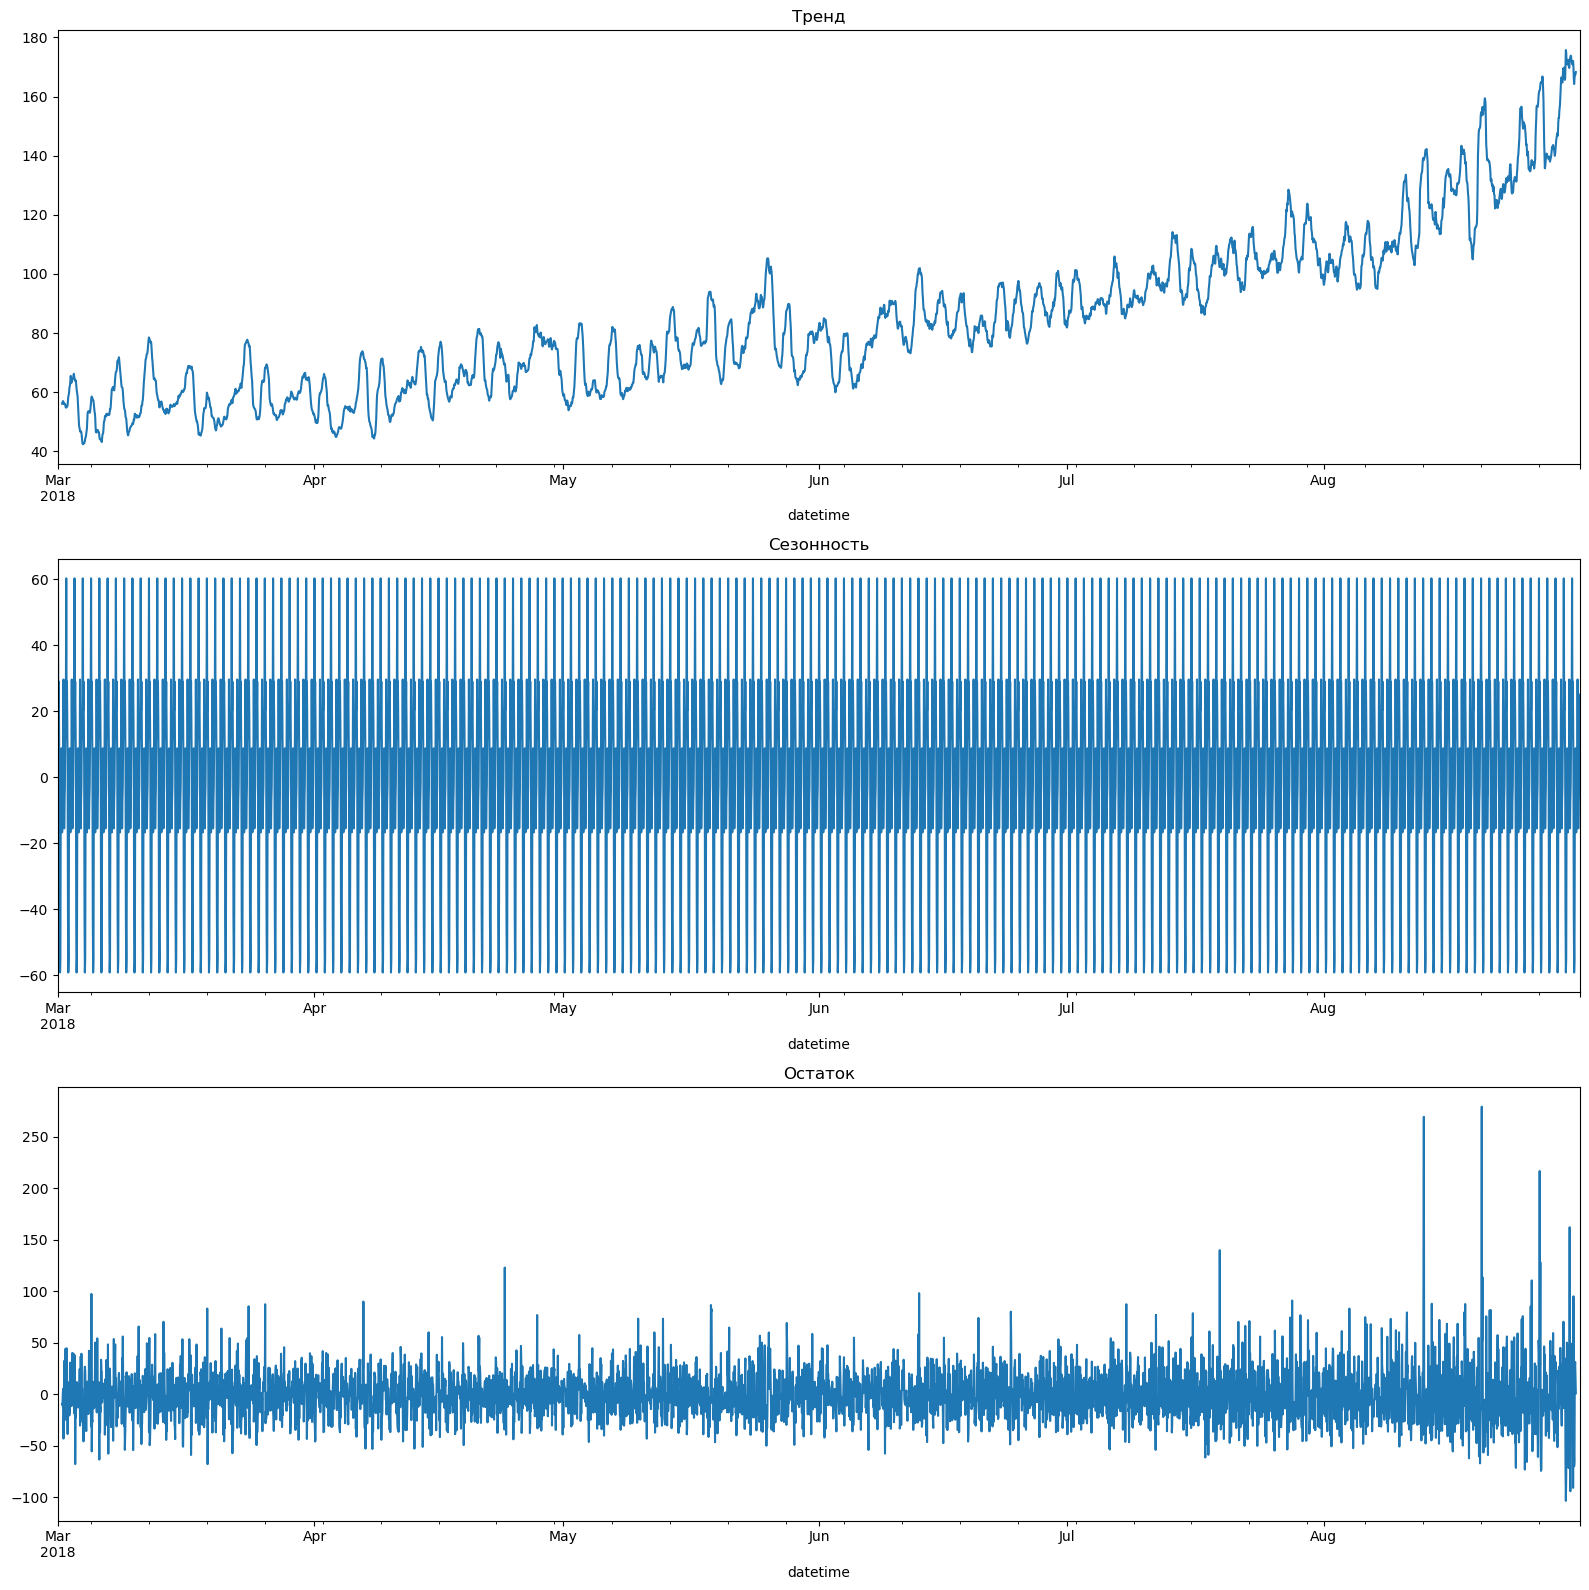

In [15]:
plt.figure(figsize=(16, 16))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)
decomposed.seasonal.plot()
plt.title('Сезонность')
plt.subplot(313)
decomposed.resid.plot()
plt.title('Остаток')
plt.tight_layout()
plt.show()

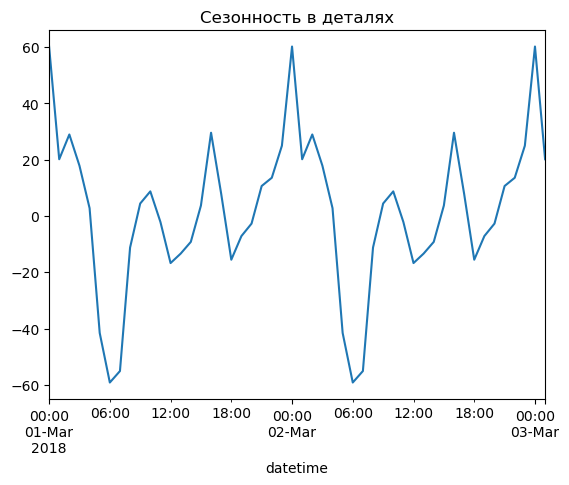

In [16]:
decomposed.seasonal[:50].plot().set_title('Сезонность в деталях');

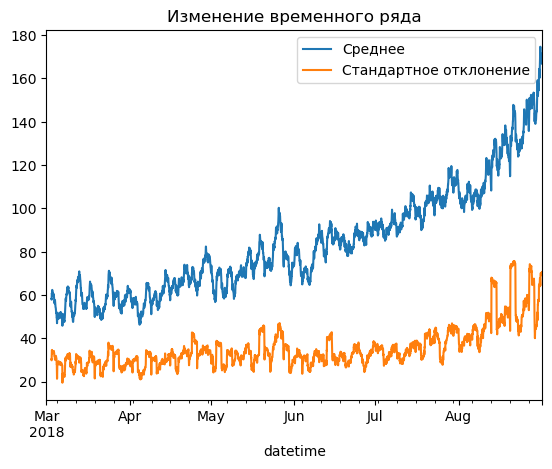

In [17]:
a = pd.DataFrame()
a['Среднее'] = cdf['num_orders'].rolling(46).mean()
a['Стандартное отклонение'] = cdf['num_orders'].rolling(46).std()
a.plot().set_title('Изменение временного ряда'); 

In [18]:
cdf.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


### Вывод

- Данные представлены в диапазоне с 2018-03-01 00:00:00 до 2018-08-31 23:00:00
- Тренд постоянно растёт с 10 до 30 заказов
- Период сезонности в данных — 24 часа. В 6:00 заказов меньше всего. В течении дня 3 пика по нарастающей количества заказов в 10:00, 16:00 и 00:00
- В среднем происходит 14 заказов в час с колебанием в 8 заказов
- Бывает что заказов нет совсем, а максимум было 77
- Среднее и стандартное отклонение временного ряда меняется со временем, значит ряд нестациоанрный

## Предобработка признаков

Делим данные на тренировочную и тестовую выборку не забыв для временных рядов отключить перемешивание (`shuffle`) которое работает у функции `train_test_split()` по умолчанию

In [19]:
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data[f'lag_{lag}'] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

make_features(cdf, 6, 26)

In [20]:
train, test = train_test_split(cdf, shuffle=False, test_size=0.1, random_state=RANDOM_STATE)
train = train.dropna()

features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']

features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

In [21]:
features_train.head()

,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,rolling_mean
datetime,,,,,,,,,,
2018-03-02 02:00:00,3,2,4,120.0,90.0,58.0,113.0,66.0,61.0,60.538462
2018-03-02 03:00:00,3,2,4,75.0,120.0,90.0,58.0,113.0,66.0,58.653846
2018-03-02 04:00:00,3,2,4,64.0,75.0,120.0,90.0,58.0,113.0,57.846154
2018-03-02 05:00:00,3,2,4,20.0,64.0,75.0,120.0,90.0,58.0,55.884615
2018-03-02 06:00:00,3,2,4,11.0,20.0,64.0,75.0,120.0,90.0,53.769231


## Обучение

In [22]:
results = {}

### Модель 1. По предыдущему значению

Перебираем один гиперпараметр для поиска лучшей модели — номер предыдущего часа от текущего, по которому предсказываем количество заказов в следующий день

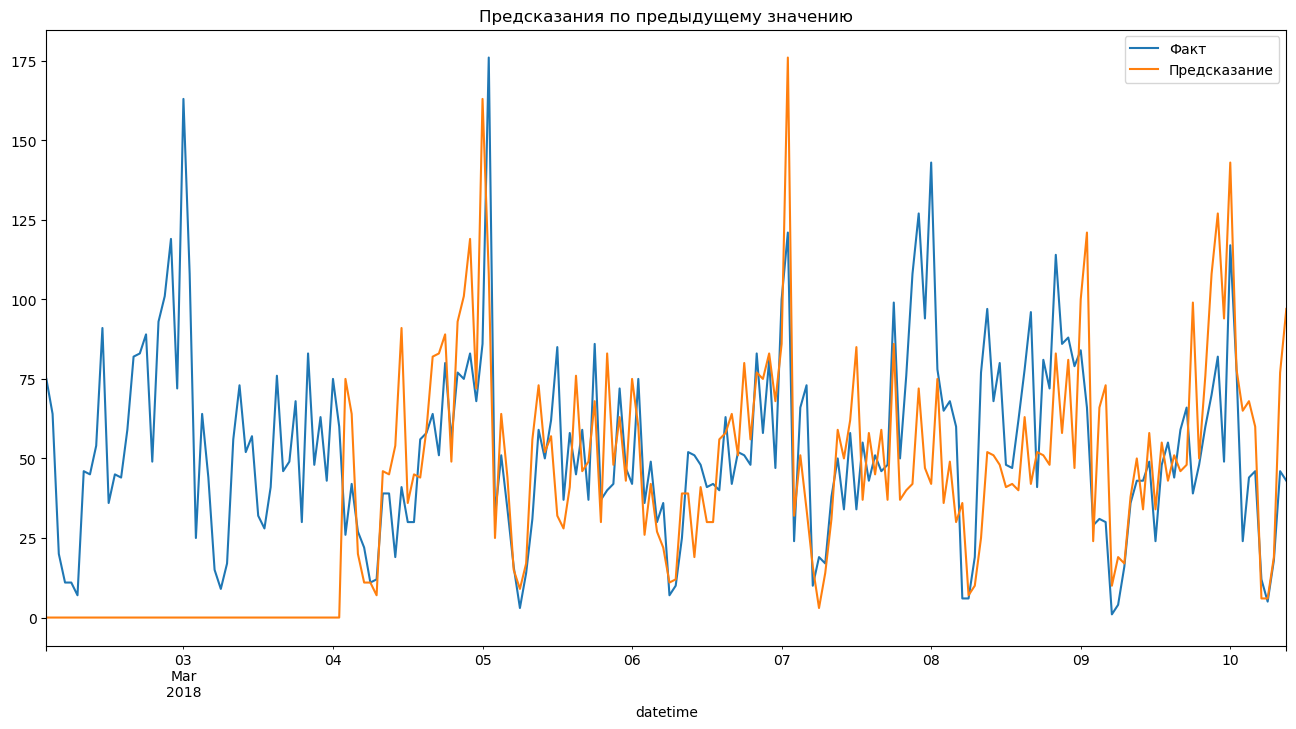

shift 48
RMSE 30.49995017186622


In [23]:
best_shift = 0
best_score = 1000
pred_previous_value_train = []

for shift in range(1, 101):
    pred = target_train.shift(shift)
    pred.iloc[0:shift] = 0
    
    RMSE = sqrt(mean_squared_error(target_train, pred))
    
    if RMSE < best_score:
        best_score = RMSE
        best_shift = shift
        pred_previous_value_train = pred

results[f'PreviousValue (shift={best_shift})'] = sqrt(mean_squared_error(target_train, pred_previous_value_train))

target_train[:200].plot(figsize=(16, 8)).set_title('Предсказания по предыдущему значению')
pred_previous_value_train[:200].plot()
plt.legend(['Факт', 'Предсказание']);
plt.show();

print('shift', best_shift)
print('RMSE', results[f'PreviousValue (shift={best_shift})'])

### Модель 2. По сколзящему среднему

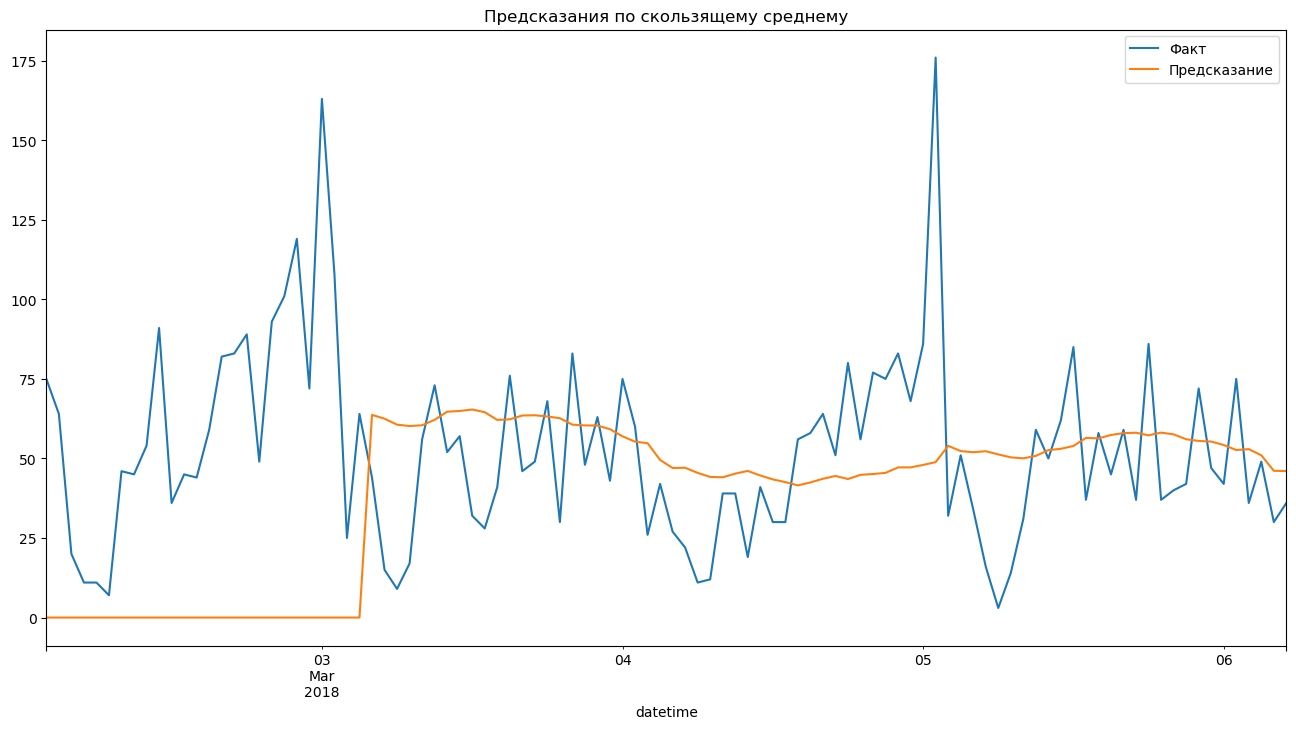

shift 26
RMSE 34.36698940716184


In [24]:
best_window = 0
best_score = 1000
pred_rolling_mean_train = []

for window in range(2, 102):
    # shift для исключения текущего значения
    pred = target_train.shift().rolling(window).mean()
    pred.iloc[0:window] = 0

    RMSE = sqrt(mean_squared_error(target_train, pred))

    if RMSE < best_score:
        best_score = RMSE
        best_window = window
        pred_rolling_mean_train = pred
        

results[f'RollingMean (window={best_window})'] = sqrt(mean_squared_error(target_train, pred_rolling_mean_train))

target_train[:100].plot(figsize=(16, 8)).set_title('Предсказания по скользящему среднему')
pred_rolling_mean_train[:100].plot()
plt.legend(['Факт', 'Предсказание']);
plt.show();

print('shift', best_window)
print('RMSE', results[f'RollingMean (window={best_window})'])

### Модель 3. LinearRegression

In [26]:
tscv = TimeSeriesSplit(n_splits=5)

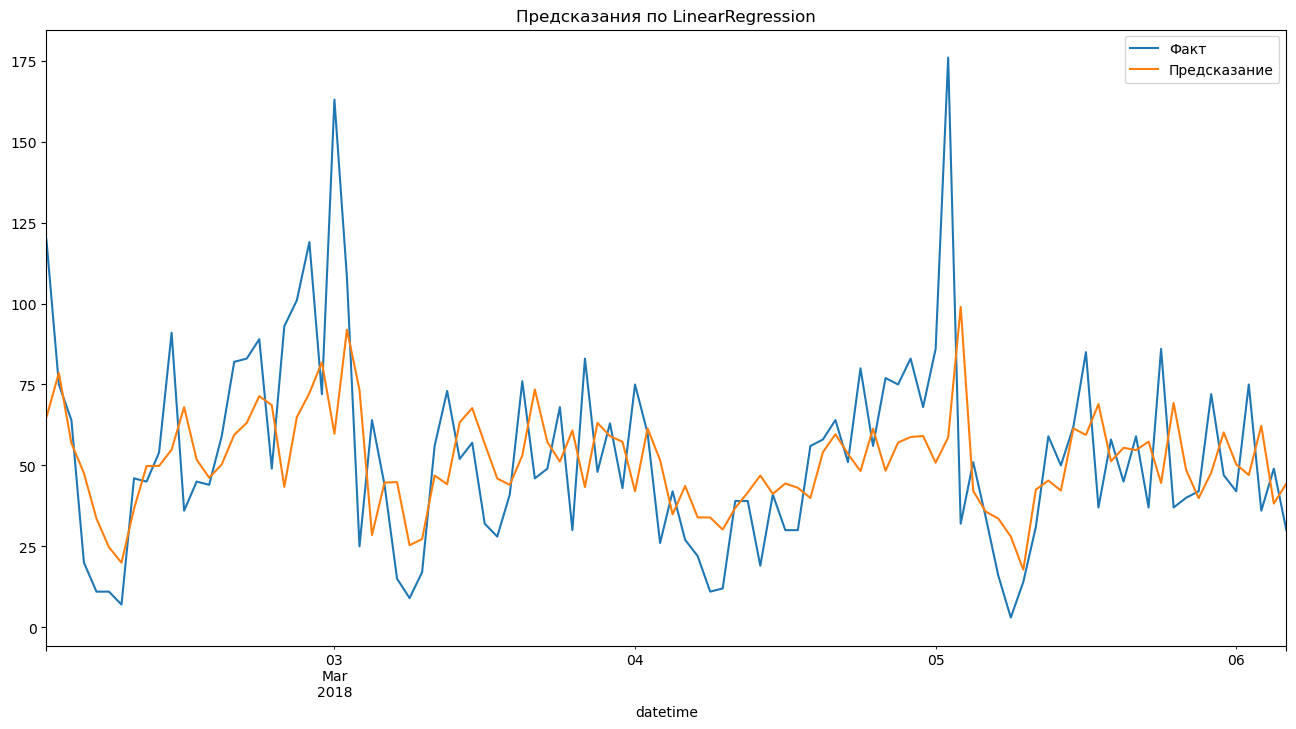

lag 9
window 25
RMSE 30.090704018384002
Лучшие гиперпараметры {'copy_X': True, 'fit_intercept': True, 'normalize': True}
CPU times: total: 5min 24s
Wall time: 54.9 s


In [27]:
%%time

best_linear_model = []
best_linear_params = []
best_max_lag = 0
best_rolling_mean_size = 0
best_score = -1000
pred_linear_train = []
best_train = []
best_test = []
best_features_train = []
best_target_train = []
best_features_test = []
best_target_test = []
linear_grid_param = {
    'fit_intercept':[True,False],
    'normalize':[True,False],
    'copy_X':[True, False]
}

for lag in range(1, 11):
    for window in range(2, 31):
        # Подготовим признаки по разному в качестве гиперпараметров
        # а именно lag и rooling_window
        make_features(cdf, lag, window)
        train, test = train_test_split(cdf, shuffle=False, test_size=0.1, random_state=RANDOM_STATE)
        train = train.dropna()

        features_train = train.drop('num_orders', axis=1)
        target_train = train['num_orders']

        features_test = test.drop('num_orders', axis=1)
        target_test = test['num_orders']
        
        linear_grid_model = GridSearchCV(
            LinearRegression(),
            param_grid=linear_grid_param,
            scoring='neg_root_mean_squared_error',
            cv=tscv
        )
        linear_grid_model.fit(features_train, target_train)
        
        pred = pd.Series(linear_grid_model.best_estimator_.predict(features_train), index=features_train.index)

        RMSE = linear_grid_model.best_score_

        if RMSE > best_score:
            best_score = RMSE
            best_linear_model = linear_grid_model.best_estimator_
            best_linear_params = linear_grid_model.best_params_
            best_max_lag = lag
            best_rolling_mean_size = window
            pred_linear_train = pred
            best_train = train
            best_test = test
            best_features_train = features_train
            best_target_train = target_train
            best_features_test = features_test
            best_target_test = target_test


best_target_train[:100].plot(figsize=(16, 8)).set_title('Предсказания по LinearRegression')
pred_linear_train[:100].plot()
plt.legend(['Факт', 'Предсказание']);
plt.show();

results[f'LinearRegression (l={best_max_lag}, w={best_rolling_mean_size})'] = \
    sqrt(mean_squared_error(best_target_train, pred_linear_train))


print('lag', best_max_lag)
print('window', best_rolling_mean_size)
print('RMSE', results[f'LinearRegression (l={best_max_lag}, w={best_rolling_mean_size})'])
print('Лучшие гиперпараметры', best_linear_params)

### Модель 4. XGBoost

In [28]:
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data[f'lag_{lag}'] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

make_features(cdf, 24, 24)

train, test = train_test_split(cdf, shuffle=False, test_size=0.1, random_state=RANDOM_STATE)
train = train.dropna()

features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']

features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

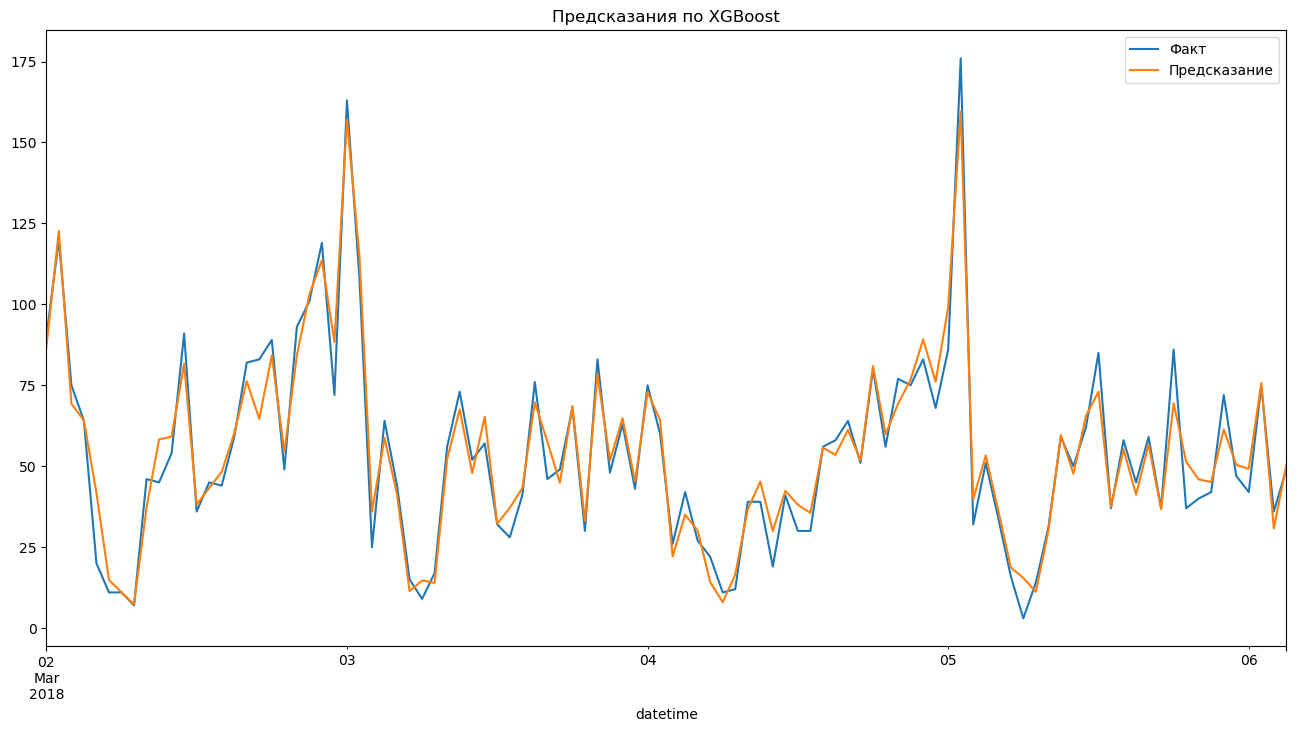

RMSE 9.228442030439744
Лучшие гиперпараметры {'colsample_bytree': 0.6, 'gamma': 5, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.8}
CPU times: total: 8min 12s
Wall time: 49.3 s


In [29]:
%%time

xgb_grid_param = {
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 5],
    'gamma': [0.5, 1, 5],
    'subsample': [0.6, 0.8],
    'colsample_bytree': [0.6, 0.8],
}

xgb_grid_model = GridSearchCV(
    xgb.XGBRegressor(),
    param_grid=xgb_grid_param,
    scoring='neg_root_mean_squared_error',
    cv=tscv
)
xgb_grid_model.fit(features_train, target_train)

pred = pd.Series(xgb_grid_model.best_estimator_.predict(features_train), index=features_train.index)

RMSE = xgb_grid_model.best_score_


target_train[:100].plot(figsize=(16, 8)).set_title('Предсказания по XGBoost')
pred[:100].plot()
plt.legend(['Факт', 'Предсказание']);
plt.show();

results['XGBoost'] = sqrt(mean_squared_error(target_train, pred))

print('RMSE', results['XGBoost'])
print('Лучшие гиперпараметры', xgb_grid_model.best_params_)

In [30]:
test_results = pd.DataFrame(results.values(), index=results.keys(), columns=['RMSE'])
test_results

,RMSE
PreviousValue (shift=48),30.499950
RollingMean (window=26),34.366989
"LinearRegression (l=9, w=25)",30.090704
XGBoost,9.228442


### Вывод

- Было рассмотрено 4 модели для предсказания временных рядов с перебором гиперпараметров: по предыдущему значению, по скользящему среднему, линейная регрессия и XGBoost
- Лучшая модель с метрикой **RMSE 9.2** — XGBoost с подготовленными признаками с временным лагом в 24 часа и окном скользящего среднего в 24 часа и другими параметрами: 'colsample_bytree': 0.8, 'gamma': 0.5, 'max_depth': 5, 'min_child_weight': 5, 'subsample': 0.8

## Тестирование лучшей модели

In [32]:
pred_test = xgb_grid_model.best_estimator_.predict(features_test)
test_metric = sqrt(mean_squared_error(target_test, pred_test))
print('RMSE', test_metric)

RMSE 45.829417578072


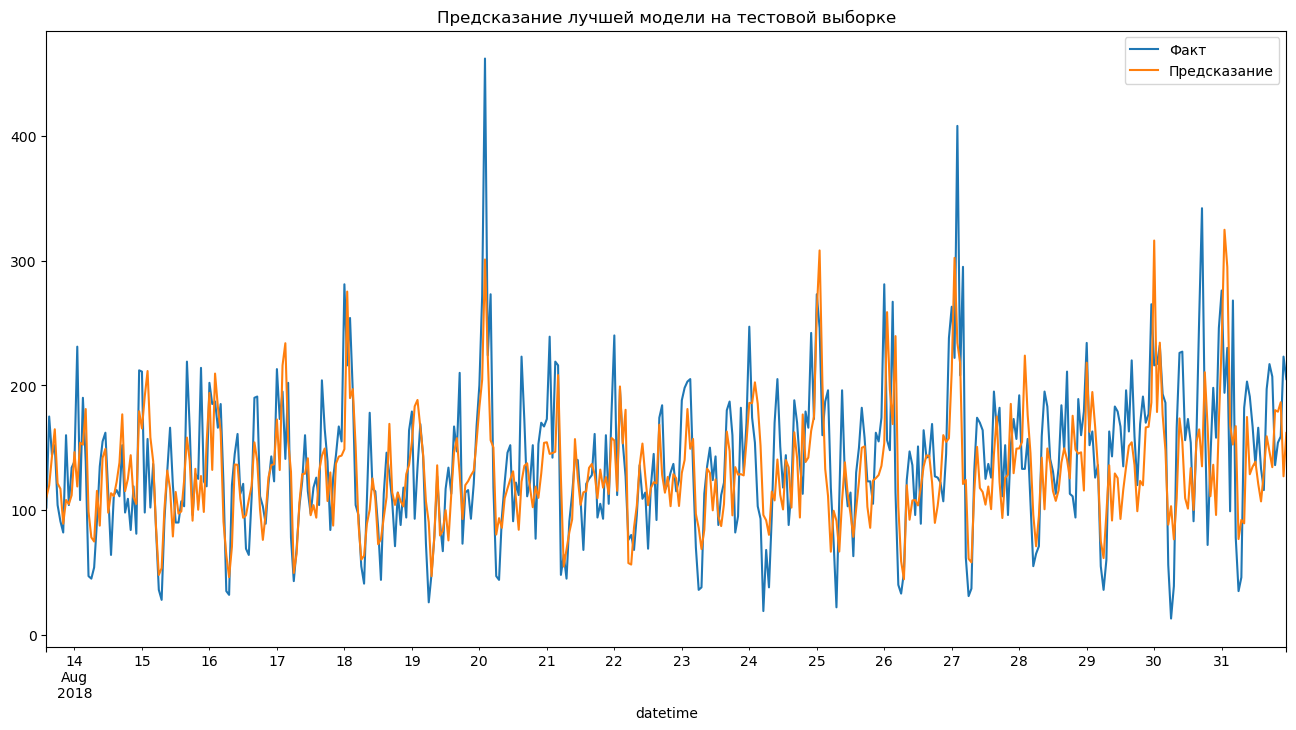

In [33]:
s = pd.DataFrame()
s['Факт'] = target_test
s['Предсказание'] = pred_test
s.plot(figsize=(16, 8)).set_title('Предсказание лучшей модели на тестовой выборке');

## Общий вывод

- Данные представлены в диапазоне с 2018-03-01 00:00:00 до 2018-08-31 23:00:00
- Тренд постоянно растёт с 10 до 30 заказов
- Период сезонности в данных — 24 часа. В 6:00 заказов меньше всего. В течении дня 3 пика по нарастающей количества заказов в 10:00, 16:00 и 00:00
- В среднем происходит 14 заказов в час с колебанием в 8 заказов
- Бывает что заказов нет совсем, а максимум было 77
- Среднее и стандартное отклонение временного ряда меняется со временем, значит ряд нестациоанрный

In [34]:
test_results

,RMSE
PreviousValue (shift=48),30.499950
RollingMean (window=26),34.366989
"LinearRegression (l=9, w=25)",30.090704
XGBoost,9.228442


- Было рассмотрено 4 модели для предсказания временных рядов с перебором гиперпараметров: по предыдущему значению, по скользящему среднему, линейная регрессия и XGBoost
- Лучшая модель с метрикой **RMSE 9.2** на кросс валидации и **RMSE 45.8** на тестовой — XGBoost с подготовленными признаками с временным лагом в 24 часа и окном скользящего среднего в 24 часа и другими параметрами: 'colsample_bytree': 0.8, 'gamma': 0.5, 'max_depth': 5, 'min_child_weight': 5, 'subsample': 0.8